In [1]:
import argparse
import copy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from sklearn.metrics import roc_auc_score

from ml import learner, data
from ml.vision import utils
from pipe import constants, augmentations

In [2]:
train = pd.read_csv(constants.train_folds_fpath)
train_df = train[train.kfold != 0].reset_index()
valid_df = train[train.kfold == 0].reset_index()

In [3]:
train_image_paths = [
    constants.data_path / f"train_1024/{x}.jpg" for x in train_df.StudyInstanceUID.values
]
train_image_paths[:5]

[PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.10980236531551060314989711662517682573.jpg'),
 PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.31644041654883936177483097186069054689.jpg'),
 PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.92698499133241834162015009420418179750.jpg'),
 PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.10069138128460654269681788885297696718.jpg'),
 PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.10994992736051720791598262985362954566.jpg')]

In [4]:
valid_image_paths = [
    constants.data_path / f"train_1024/{x}.jpg" for x in valid_df.StudyInstanceUID.values
]
valid_image_paths[:5]

[PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.46532475818207697815838596694519250331.jpg'),
 PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.71220172190076666584059125496194010134.jpg'),
 PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.13129310403067333749186320526401448292.jpg'),
 PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.61241754699149924369695429405706068683.jpg'),
 PosixPath('/home/gianluca/git/kaggle/ranzcr/data/train_1024/1.2.826.0.1.3680043.8.498.13200337440685816759054494914508184724.jpg')]

In [5]:
train_targets = train_df.loc[:, constants.target_cols].values
valid_targets = valid_df.loc[:, constants.target_cols].values

In [6]:
hparams = argparse.Namespace(
    arch='resnest200e',
    sz=512,
    batch_size=8,
    epochs=15,
    lr=0.01,
    mom=0.9,
    wd=0.00001,
    loss='bce_with_logits',
    metric='multilabel_auc_macro',
    label_smoothing=0.05,
    opt='sam',
    aug='baseline',
    sched='onecycle',
    train_data=constants.data_path / 'train_1024',
    precision=32,
)

In [7]:
train_aug, valid_aug, test_aug = augmentations.augmentations_factory(hparams)

In [8]:
def find_lr():
    dm = data.ImageDataModule(
        batch_size=hparams.batch_size,
        # train
        train_image_paths=train_image_paths,
        train_targets=train_targets,
        train_augmentations=train_aug,
        # valid, max_lr
        valid_image_paths=valid_image_paths,
        valid_targets=valid_targets,
        valid_augmentations=valid_aug,
    )
    dm.setup()
    model = learner.ImageClassifier(
        in_channels=1,
        num_classes=11,
        pretrained=True,
        **vars(hparams),
    )

    trainer = pl.Trainer(
        gpus=1,
        precision=hparams.precision,
        max_epochs=hparams.epochs,
#         auto_scale_batch_size=True
    )

    trainer.tune(model, dm)

    lr_finder = trainer.tuner.lr_find(model, max_lr=10)

    return lr_finder.plot(suggest=True)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 68.2 M
---------------------------------
68.2 M    Trainable params
0         Non-trainable params
68.2 M    Total params
272.696   Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /home/gianluca/git/kaggle/ranzcr/nbs/lr_find_temp_model.ckpt


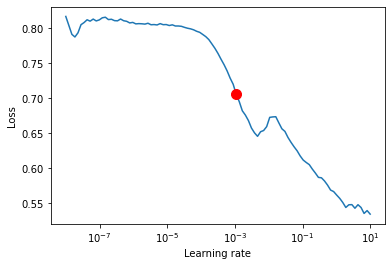

In [9]:
fig = find_lr()
fig.show()

In [13]:
max_lr     = 10**-1  # if loss starts diverging after 10**1, choose 10**0
initial_lr = max_lr / 25.
min_lr     = max_lr / 10_000.

print(f"Initial LR={initial_lr}, Max LR={max_lr}, Min LR={min_lr}")

Initial LR=0.004, Max LR=0.1, Min LR=1e-05
